# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# # Here is a helping code that will download and unzip the dataset for you.
# # Once you download the dataset you may comment the code!
# !kaggle datasets download -d khaledzsa/traffic-dataset
# !unzip traffic-dataset.zip

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU
from keras.optimizers import SGD
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import datetime as dt

In [3]:
df = pd.read_csv('D:\\Tuwaiq Academy\\Tuwaiq_Academy_T5_Week_6\\5- Weekly Project\\Datasets\\Traffic Data.csv')
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [4]:
df.dtypes

traffic_volume         float64
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time               object
dtype: object

In [5]:
df['date_time'] = pd.to_datetime(df['date_time'])
df.dtypes

traffic_volume                float64
temp                          float64
rain_1h                       float64
snow_1h                       float64
clouds_all                      int64
weather_main                   object
weather_description            object
date_time              datetime64[ns]
dtype: object

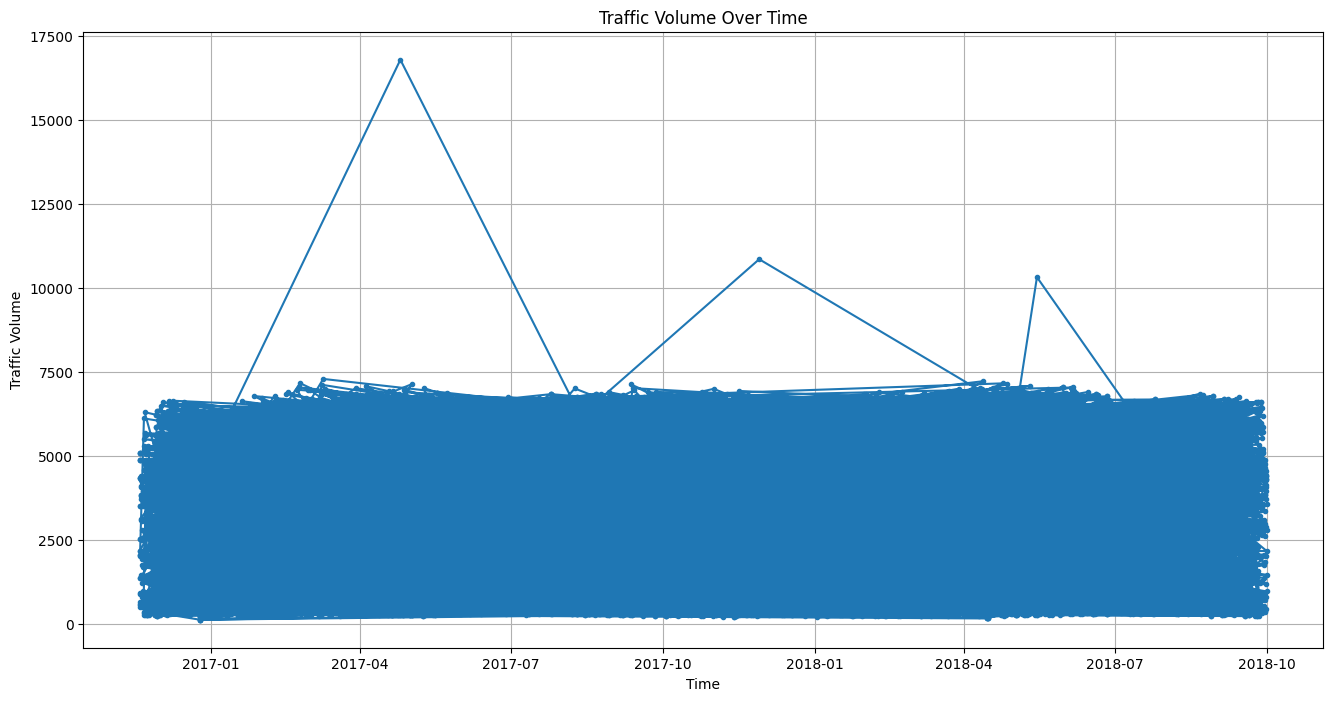

In [6]:
plt.figure(figsize=(16,8))
plt.plot(df['date_time'], df['traffic_volume'], marker='.')
plt.title('Traffic Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.show()

In [7]:
df.sort_values(by=['date_time'], ascending=True, inplace=True)
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
7745,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,2016-11-18 15:00:00
4628,4872.0,274.08,0.0,0.0,90,Fog,fog,2016-11-18 15:00:00
14496,4872.0,274.08,0.0,0.0,90,Mist,mist,2016-11-18 15:00:00
8867,5074.0,273.84,0.0,0.0,90,Fog,fog,2016-11-18 16:00:00
3867,5074.0,273.84,0.0,0.0,90,Mist,mist,2016-11-18 16:00:00


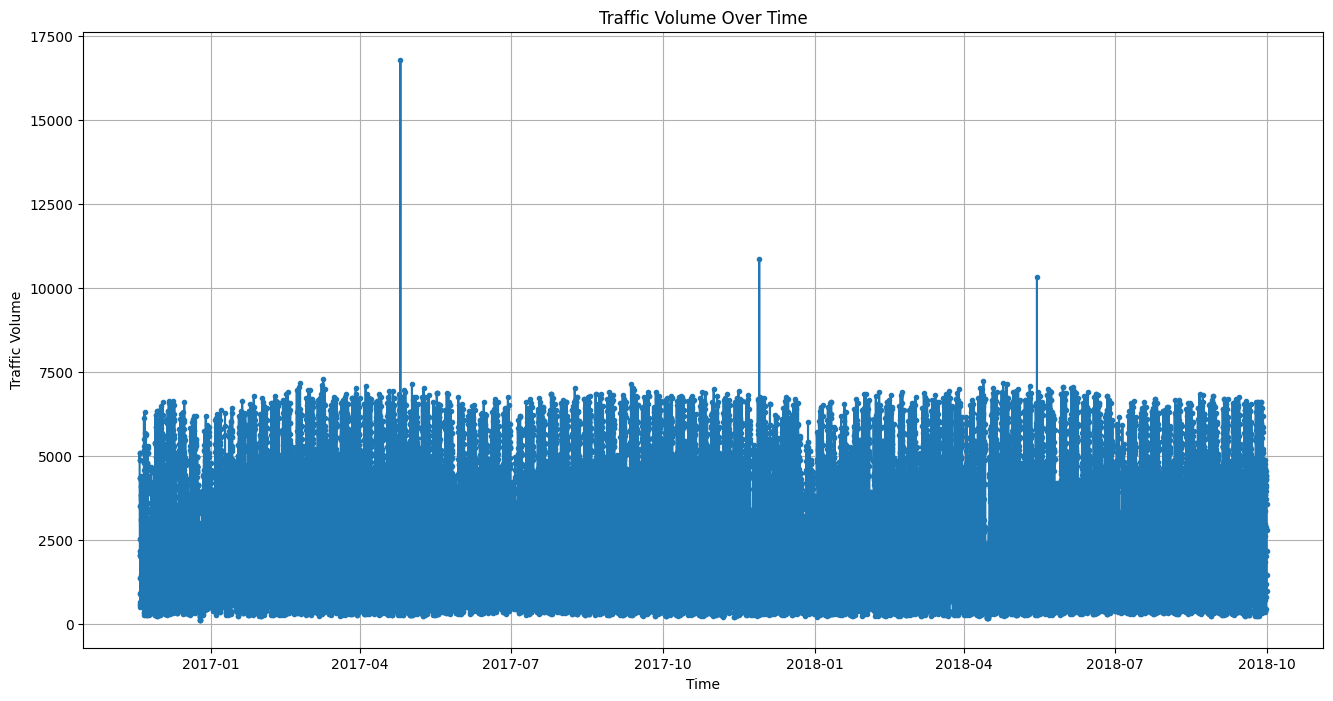

In [8]:
plt.figure(figsize=(16,8))
plt.plot(df['date_time'], df['traffic_volume'], marker='.')
plt.title('Traffic Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.show()

<Axes: >

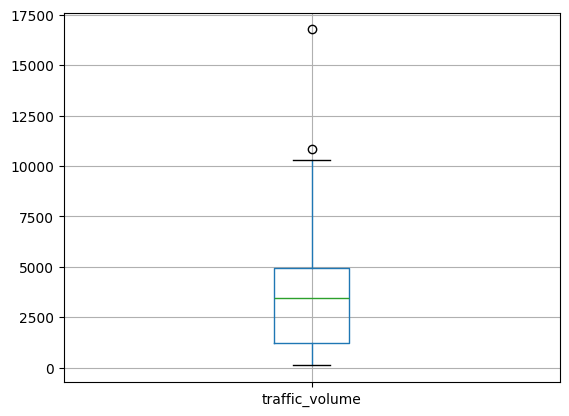

In [9]:
df.boxplot(column=['traffic_volume'])

In [10]:
new_df = df.copy()
new_df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_main', 'weather_description', 'date_time'],
      dtype='object')

In [11]:
new_df.drop(['temp', 'rain_1h', 'clouds_all', 'weather_main',
       'weather_description','snow_1h'], axis=1, inplace=True)
new_df.columns

Index(['traffic_volume', 'date_time'], dtype='object')

In [12]:
new_df

,traffic_volume,date_time
7745,4872.0,2016-11-18 15:00:00
4628,4872.0,2016-11-18 15:00:00
14496,4872.0,2016-11-18 15:00:00
8867,5074.0,2016-11-18 16:00:00
3867,5074.0,2016-11-18 16:00:00
...,...,...
6605,3543.0,2018-09-30 19:00:00
14241,2781.0,2018-09-30 20:00:00
9500,2159.0,2018-09-30 21:00:00
15201,1450.0,2018-09-30 22:00:00


In [13]:
new_df.reset_index(inplace=True)
new_df

,index,traffic_volume,date_time
0,7745,4872.0,2016-11-18 15:00:00
1,4628,4872.0,2016-11-18 15:00:00
2,14496,4872.0,2016-11-18 15:00:00
3,8867,5074.0,2016-11-18 16:00:00
4,3867,5074.0,2016-11-18 16:00:00
...,...,...,...
19995,6605,3543.0,2018-09-30 19:00:00
19996,14241,2781.0,2018-09-30 20:00:00
19997,9500,2159.0,2018-09-30 21:00:00
19998,15201,1450.0,2018-09-30 22:00:00


In [14]:
new_df.drop(['date_time', 'index'], axis=1,inplace=True)
new_df

,traffic_volume
0,4872.0
1,4872.0
2,4872.0
3,5074.0
4,5074.0
...,...
19995,3543.0
19996,2781.0
19997,2159.0
19998,1450.0


In [15]:
model = ExponentialSmoothing(new_df, seasonal_periods=12, trend='add', seasonal='add')
model_triple_fit = model.fit()

C:\Users\abo_O\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [16]:
forecast_triple = model_triple_fit.forecast(40)
print(forecast_triple)

20000   NaN
20001   NaN
20002   NaN
20003   NaN
20004   NaN
20005   NaN
20006   NaN
20007   NaN
20008   NaN
20009   NaN
20010   NaN
20011   NaN
20012   NaN
20013   NaN
20014   NaN
20015   NaN
20016   NaN
20017   NaN
20018   NaN
20019   NaN
20020   NaN
20021   NaN
20022   NaN
20023   NaN
20024   NaN
20025   NaN
20026   NaN
20027   NaN
20028   NaN
20029   NaN
20030   NaN
20031   NaN
20032   NaN
20033   NaN
20034   NaN
20035   NaN
20036   NaN
20037   NaN
20038   NaN
20039   NaN
dtype: float64


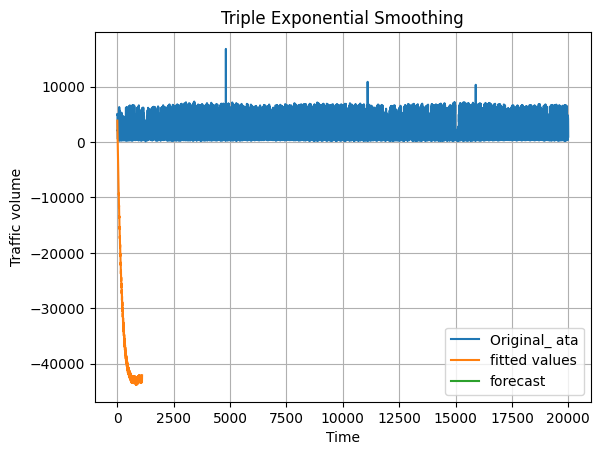

In [17]:
plt.plot(new_df, label='Original_ ata')
plt.plot(model_triple_fit.fittedvalues, label='fitted values')
plt.plot(forecast_triple, label='forecast')
plt.legend()
plt.title('Triple Exponential Smoothing')
plt.xlabel('Time')
plt.ylabel('Traffic volume')
plt.grid(True)
plt.show()

# the forecasting gives nan values I think becouse it couldn't detect trend or seasonalty 

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [18]:
df.isna().sum()

traffic_volume         20
temp                    0
rain_1h                 0
snow_1h                 0
clouds_all              0
weather_main            0
weather_description     0
date_time               0
dtype: int64

In [19]:
df.fillna(method='pad',inplace=True)
df.isna().sum()

C:\Users\abo_O\AppData\Local\Temp\ipykernel_6616\1698150463.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='pad',inplace=True)


traffic_volume         0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
dtype: int64

In [20]:
df.duplicated().sum()

12

In [21]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [22]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
7745,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,2016-11-18 15:00:00
4628,4872.0,274.08,0.0,0.0,90,Fog,fog,2016-11-18 15:00:00
14496,4872.0,274.08,0.0,0.0,90,Mist,mist,2016-11-18 15:00:00
8867,5074.0,273.84,0.0,0.0,90,Fog,fog,2016-11-18 16:00:00
3867,5074.0,273.84,0.0,0.0,90,Mist,mist,2016-11-18 16:00:00


In [23]:
df['rain_1h'].unique()

array([ 0.  ,  1.02,  1.27,  0.25,  0.51,  0.98,  0.42,  0.38,  2.41,
        2.03,  4.  ,  5.84,  2.76,  2.2 ,  2.88,  1.82,  5.62,  2.86,
        0.76,  1.78,  0.63,  5.08,  0.93,  1.15,  4.06,  1.85,  1.52,
        2.79,  1.1 ,  0.61,  0.89,  0.43,  0.71,  1.4 ,  0.85,  0.81,
        3.94,  3.4 ,  0.64,  0.34,  0.44,  0.32,  2.62,  0.69,  1.21,
        1.14,  2.61,  1.6 ,  2.92,  3.1 ,  2.6 ,  1.45,  2.26,  1.06,
        0.28,  0.29,  3.3 ,  3.05,  2.29,  2.54,  2.85,  3.45,  2.48,
        0.3 ,  0.35,  2.16,  1.72,  1.68,  5.12,  3.18,  1.01,  1.86,
        1.65,  0.8 ,  1.66,  1.3 ,  0.86,  4.15,  4.79,  5.42,  5.19,
        9.62, 10.6 ,  7.11,  2.96,  4.74,  0.66])

In [24]:
df['snow_1h'].unique()

array([0.])

In [25]:
df.drop('snow_1h', axis=1, inplace=True)
df.head()

,traffic_volume,temp,rain_1h,clouds_all,weather_main,weather_description,date_time
7745,4872.0,274.08,0.0,90,Snow,heavy snow,2016-11-18 15:00:00
4628,4872.0,274.08,0.0,90,Fog,fog,2016-11-18 15:00:00
14496,4872.0,274.08,0.0,90,Mist,mist,2016-11-18 15:00:00
8867,5074.0,273.84,0.0,90,Fog,fog,2016-11-18 16:00:00
3867,5074.0,273.84,0.0,90,Mist,mist,2016-11-18 16:00:00


In [26]:
df['clouds_all'].unique()

array([90, 40,  1, 75, 20,  5, 64, 80, 76,  0,  8, 12, 32, 68, 92, 88, 24,
       36, 48, 44, 56], dtype=int64)

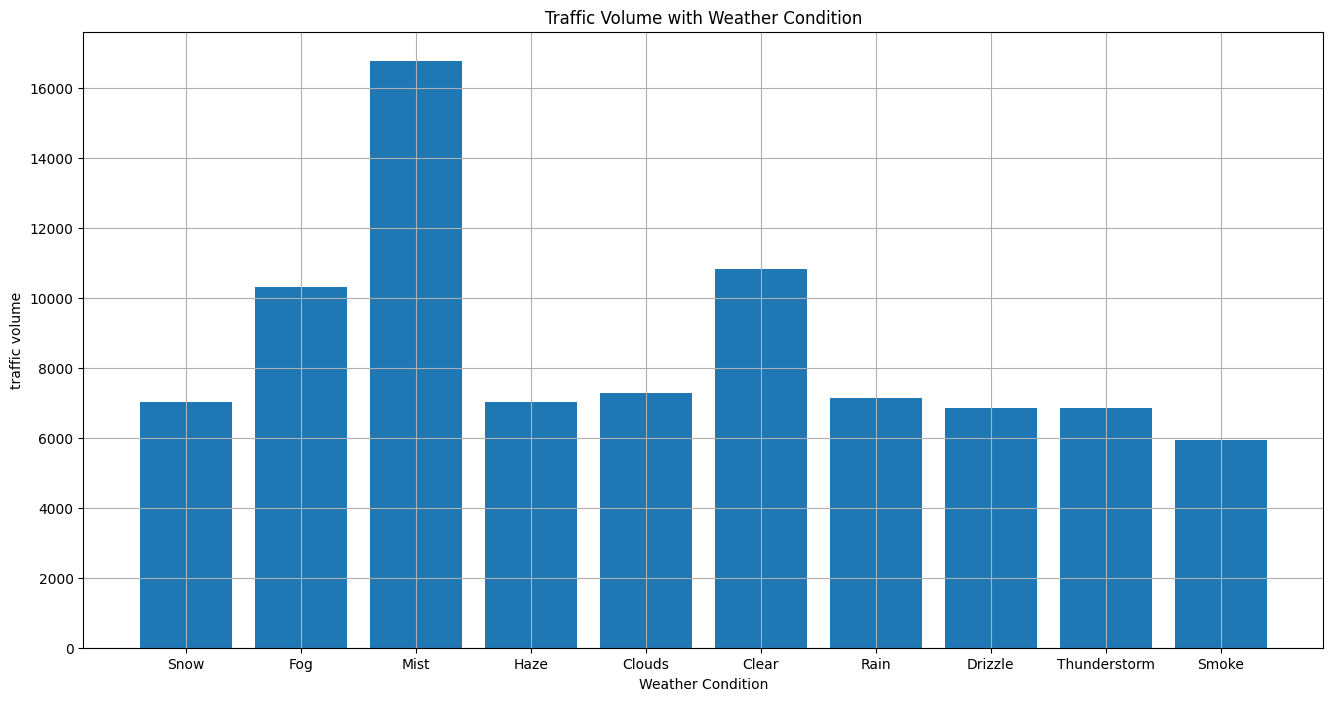

In [27]:
plt.figure(figsize=(16,8))
plt.bar(df['weather_main'], df['traffic_volume'])
plt.title('Traffic Volume with Weather Condition')
plt.ylabel('traffic volume')
plt.xlabel('Weather Condition')
plt.grid(True)
plt.show()

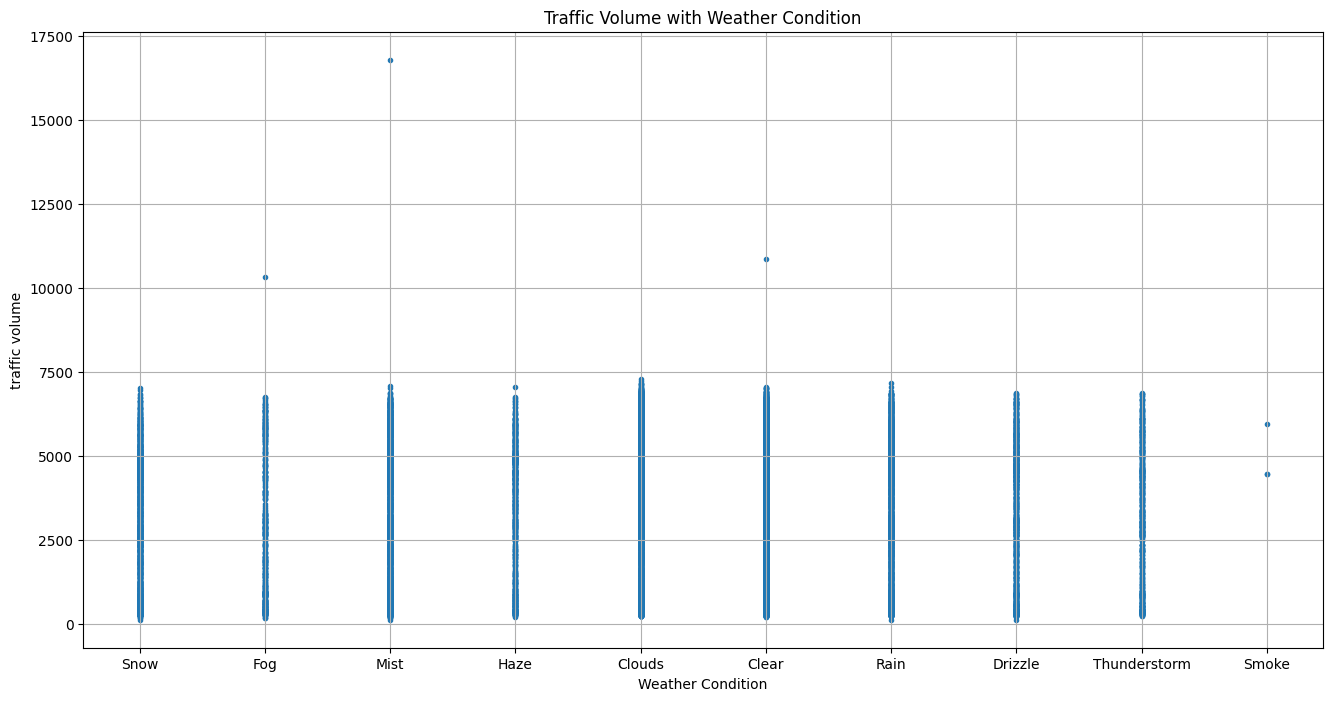

In [28]:
plt.figure(figsize=(16,8))
plt.scatter(df['weather_main'], df['traffic_volume'], marker='.')
plt.title('Traffic Volume with Weather Condition')
plt.ylabel('traffic volume')
plt.xlabel('Weather Condition')
plt.grid(True)
plt.show()

In [29]:
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time'],
      dtype='object')

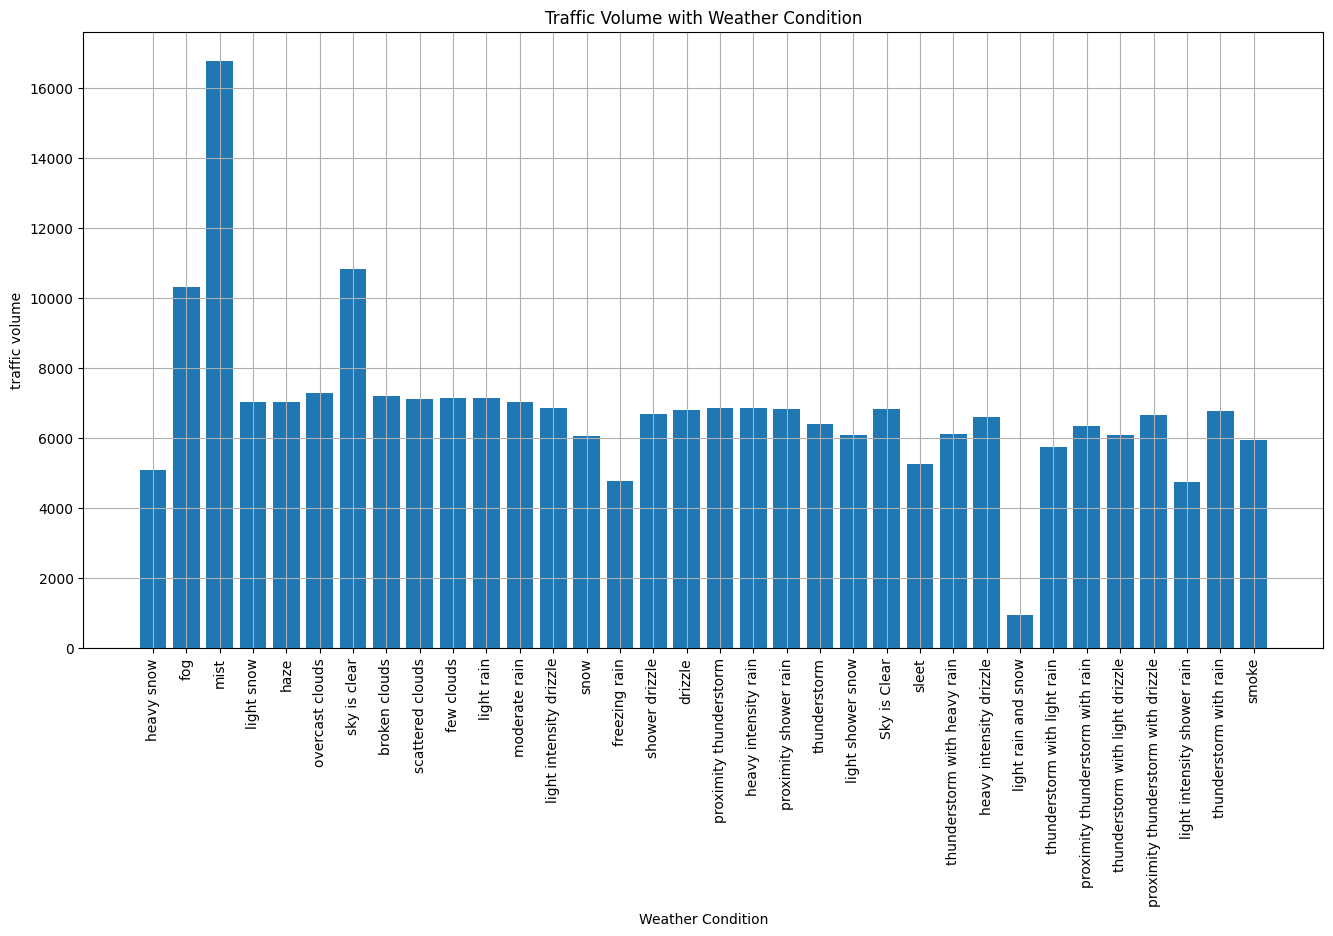

In [30]:
plt.figure(figsize=(16,8))
plt.bar(df['weather_description'], df['traffic_volume'])
plt.title('Traffic Volume with Weather Condition')
plt.ylabel('traffic volume')
plt.xlabel('Weather Condition')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [31]:
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time'],
      dtype='object')

In [32]:
lags = [1, 2, 3]

for lag in lags:
    df[f'traffic_volume_lag{lag}'] = df['traffic_volume'].shift(lag)

In [33]:
window = [3, 7, 14]

for window in window:
    df[f'traffic_volume_ma{window}'] = df['traffic_volume'].rolling(window=window).mean()

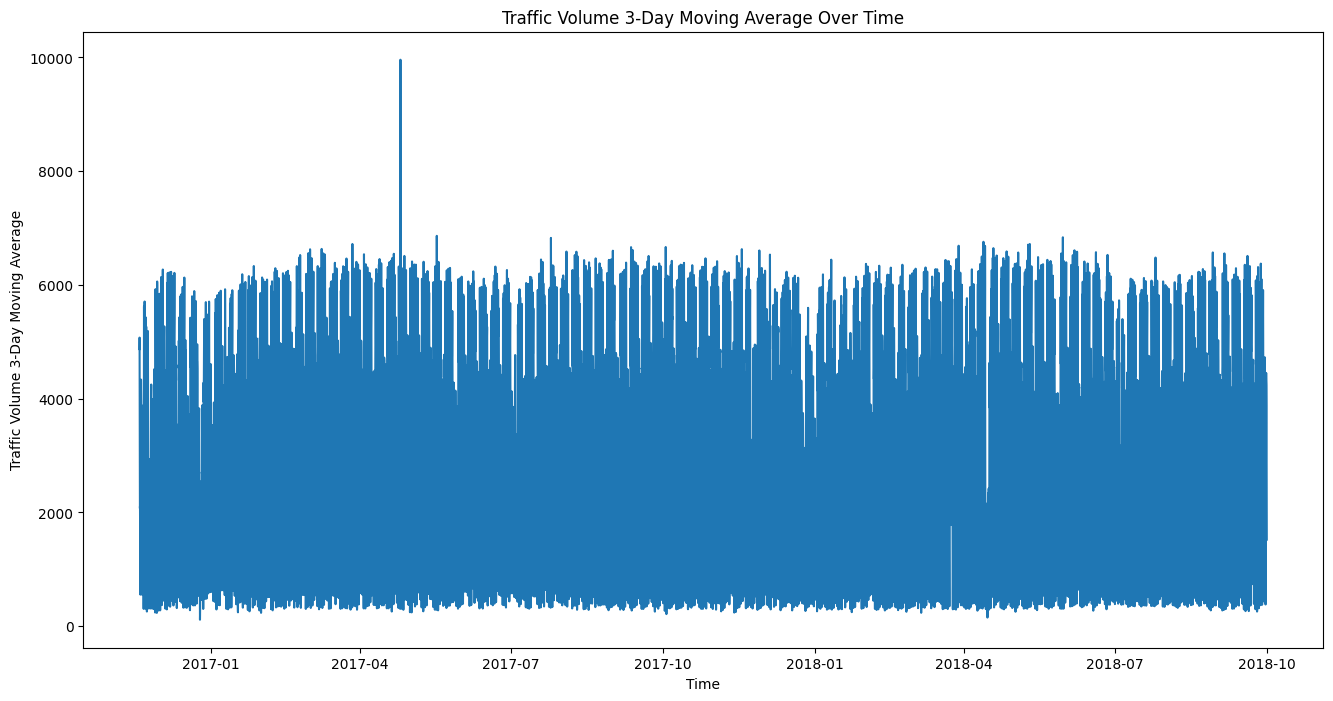

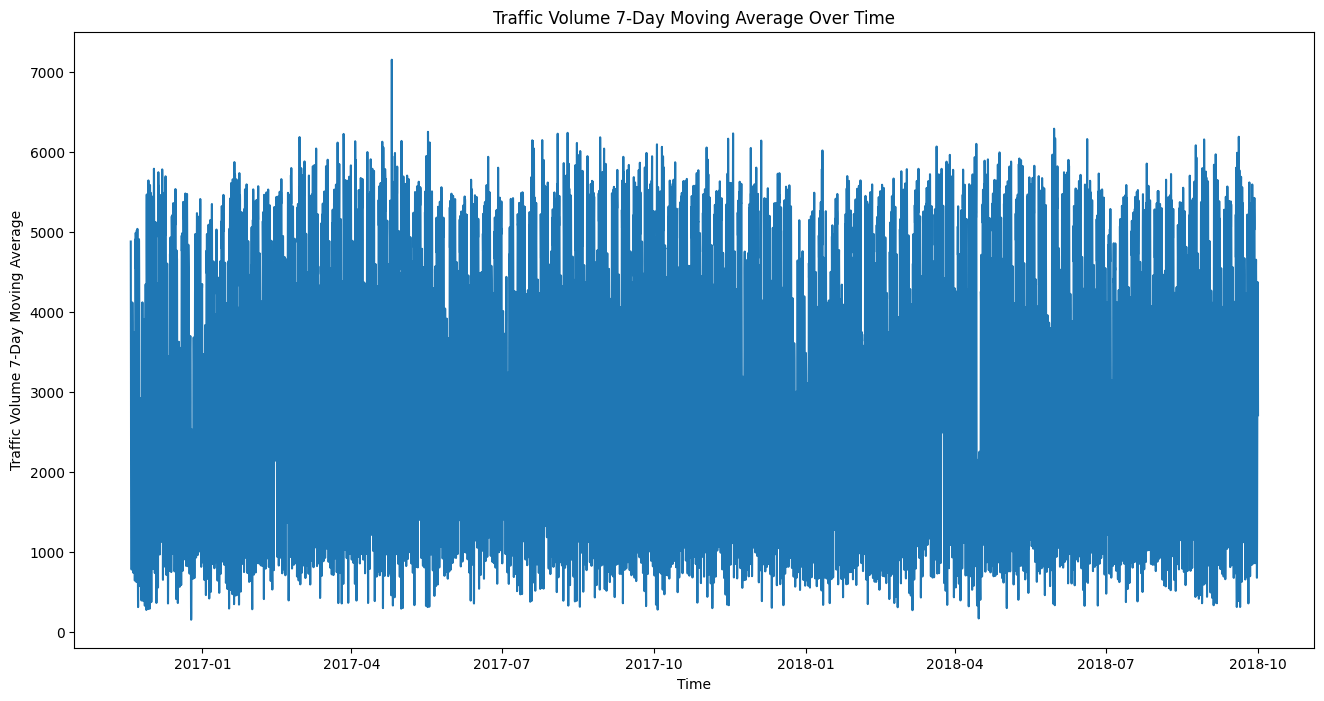

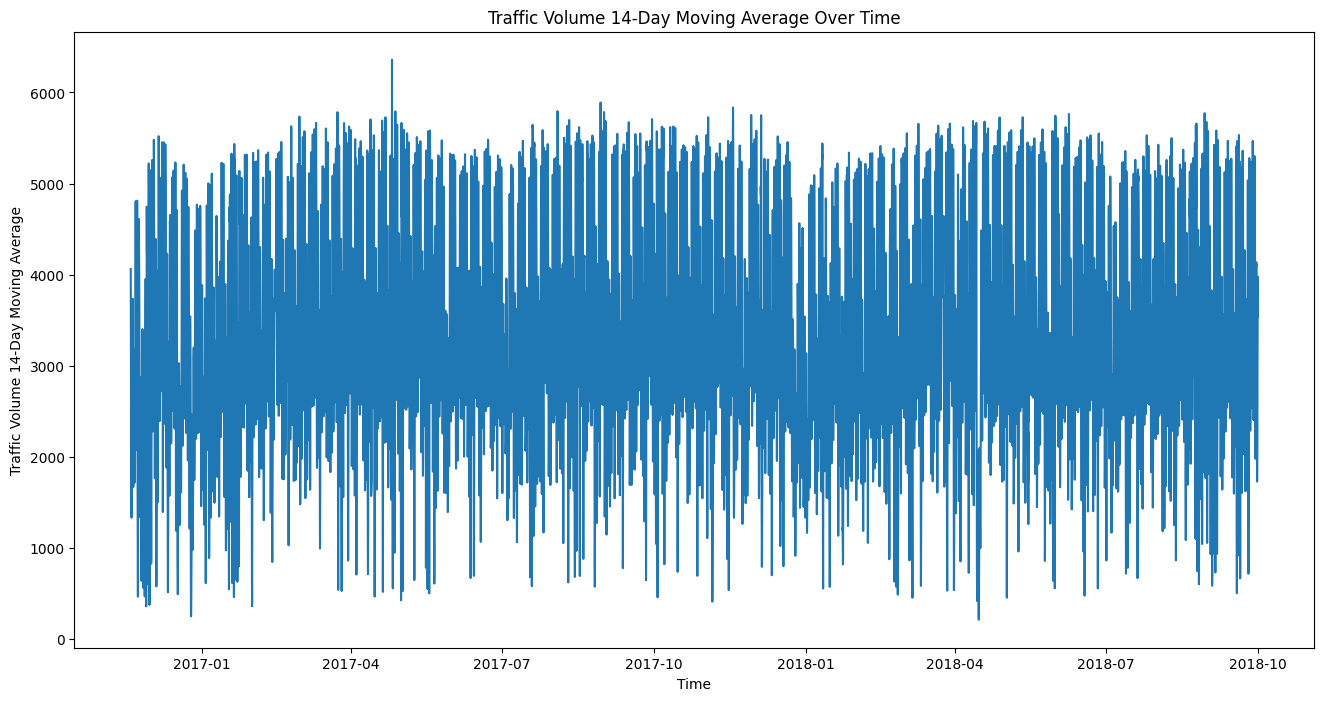

In [34]:
window = [3, 7, 14]
for window in window:
    plt.figure(figsize=(16,8))
    plt.plot(df['date_time'], df[f'traffic_volume_ma{window}'])
    plt.title(f'Traffic Volume {window}-Day Moving Average Over Time')
    plt.xlabel('Time')
    plt.ylabel(f'Traffic Volume {window}-Day Moving Average')
    plt.show()

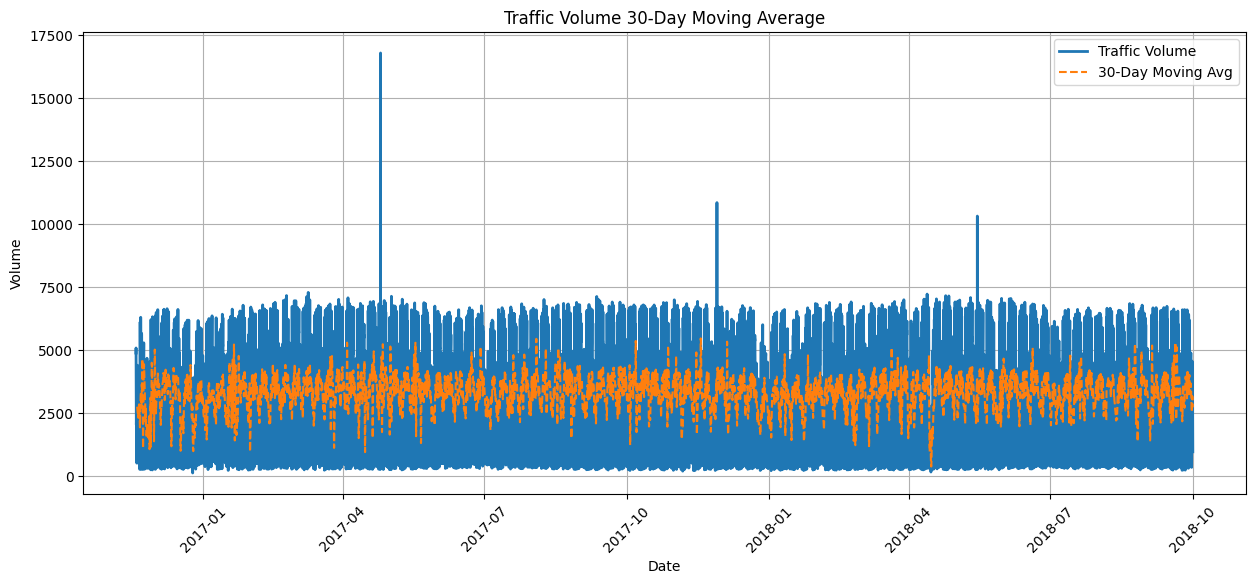

In [35]:
window = 30
plt.figure(figsize=(15, 6))
plt.plot(df['date_time'], df['traffic_volume'], label='Traffic Volume', linewidth=2)
plt.plot(df['date_time'], df['traffic_volume'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Traffic Volume {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

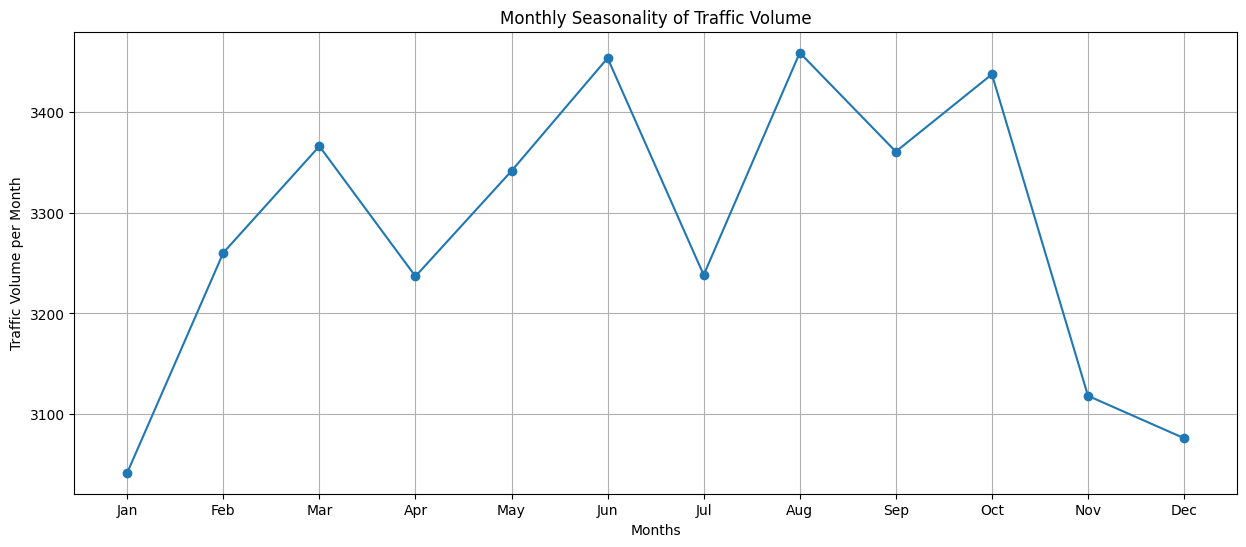

In [36]:
df['Month'] = df['date_time'].dt.month

monthly_average = df.groupby('Month')['traffic_volume'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of Traffic Volume')
plt.xlabel('Months')
plt.ylabel('Traffic Volume per Month')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [37]:
df['prev_traffic_volume'] = df['traffic_volume'].shift(1)
df['traffic_volume_diff'] = df['traffic_volume'].diff()

In [38]:
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume_lag1',
       'traffic_volume_lag2', 'traffic_volume_lag3', 'traffic_volume_ma3',
       'traffic_volume_ma7', 'traffic_volume_ma14', 'Month',
       'prev_traffic_volume', 'traffic_volume_diff'],
      dtype='object')

In [39]:
df['month'] = df['date_time'].dt.month
df['day_of_week'] = df['date_time'].dt.day_of_week
df['day_of_year'] = df['date_time'].dt.day_of_year
df['isWeekend'] = df['day_of_week'].apply(lambda x : 1 if x >= 5 else 0)
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume_lag1',
       'traffic_volume_lag2', 'traffic_volume_lag3', 'traffic_volume_ma3',
       'traffic_volume_ma7', 'traffic_volume_ma14', 'Month',
       'prev_traffic_volume', 'traffic_volume_diff', 'month', 'day_of_week',
       'day_of_year', 'isWeekend'],
      dtype='object')

In [40]:
print('old shape:', df['traffic_volume'].shape)

old shape: (19988,)


In [41]:
Q1 = df['traffic_volume'].quantile(0.25)
Q3 = df['traffic_volume'].quantile(0.75)
IQR = Q3 -Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

upper_array = np.where(df['traffic_volume'] >= upper)[0]
lower_array = np.where(df['traffic_volume'] <= lower)[0]

df.drop(index=upper_array, inplace=True)
df.drop(index=lower_array, inplace=True)
print('new shape:', df['traffic_volume'].shape)

new shape: (19986,)


In [42]:
sec_df = df.copy()
sec_df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume_lag1',
       'traffic_volume_lag2', 'traffic_volume_lag3', 'traffic_volume_ma3',
       'traffic_volume_ma7', 'traffic_volume_ma14', 'Month',
       'prev_traffic_volume', 'traffic_volume_diff', 'month', 'day_of_week',
       'day_of_year', 'isWeekend'],
      dtype='object')

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [43]:
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume_lag1',
       'traffic_volume_lag2', 'traffic_volume_lag3', 'traffic_volume_ma3',
       'traffic_volume_ma7', 'traffic_volume_ma14', 'Month',
       'prev_traffic_volume', 'traffic_volume_diff', 'month', 'day_of_week',
       'day_of_year', 'isWeekend'],
      dtype='object')

In [44]:
df.isna().sum()

traffic_volume          0
temp                    0
rain_1h                 0
clouds_all              0
weather_main            0
weather_description     0
date_time               0
traffic_volume_lag1     1
traffic_volume_lag2     2
traffic_volume_lag3     3
traffic_volume_ma3      2
traffic_volume_ma7      6
traffic_volume_ma14    13
Month                   0
prev_traffic_volume     1
traffic_volume_diff     1
month                   0
day_of_week             0
day_of_year             0
isWeekend               0
dtype: int64

In [45]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
new_df = df.copy()
new_df['weather_main'] = le.fit_transform(new_df['weather_main'])
new_df['weather_description'] = le.fit_transform(new_df['weather_description'])
new_df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume_lag1',
       'traffic_volume_lag2', 'traffic_volume_lag3', 'traffic_volume_ma3',
       'traffic_volume_ma7', 'traffic_volume_ma14', 'Month',
       'prev_traffic_volume', 'traffic_volume_diff', 'month', 'day_of_week',
       'day_of_year', 'isWeekend'],
      dtype='object')

In [46]:
new_df.dtypes

traffic_volume                float64
temp                          float64
rain_1h                       float64
clouds_all                      int64
weather_main                    int32
weather_description             int32
date_time              datetime64[ns]
traffic_volume_lag1           float64
traffic_volume_lag2           float64
traffic_volume_lag3           float64
traffic_volume_ma3            float64
traffic_volume_ma7            float64
traffic_volume_ma14           float64
Month                           int32
prev_traffic_volume           float64
traffic_volume_diff           float64
month                           int32
day_of_week                     int32
day_of_year                     int32
isWeekend                       int64
dtype: object

In [47]:
new_df = df['traffic_volume']
new_df

7745     4872.0
4628     4872.0
14496    4872.0
8867     5074.0
3867     5074.0
          ...  
6605     3543.0
14241    2781.0
9500     2159.0
15201    1450.0
3795      954.0
Name: traffic_volume, Length: 19986, dtype: float64

In [48]:
train_size = int(len(new_df) * 0.8)
train_size

15988

In [49]:
train_data, test_data = new_df[:train_size], new_df[train_size:]

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data=scaler.fit_transform(np.array(train_data).reshape(-1,1))
test_data= scaler.transform(np.array(test_data).reshape(-1,1))
train_data, test_data

(array([[0.28551716],
        [0.28551716],
        [0.28551716],
        ...,
        [0.10103192],
        [0.07841373],
        [0.04451644]]),
 array([[0.03155748],
        [0.02285817],
        [0.02183825],
        ...,
        [0.12275018],
        [0.08021358],
        [0.05045596]]))

In [51]:
n_past = 7

# Prepare sequences for RNN
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [52]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(15981, 7)
(15981,)


Testing set size:-
(3991, 7)
(3991,)


(None, None)

In [53]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [54]:
model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.5),
    SimpleRNN(50),
    Dropout(0.5),
    Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

C:\Users\abo_O\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 7, 50)          │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,701 (30.08 KB)

 Trainable params: 7,701 (30.08 KB)

 Non-trainable params: 0 (0.00 B)

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [55]:
checkpoints = ModelCheckpoint(filepath = 'my_weights.keras', save_best_only = True)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0337 - val_loss: 0.0017
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 10/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 11/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 12/100
500/500 ━━━━━━━━━━━━━━━━━━━━

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [56]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [57]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [58]:
def plot_pred(test, pred):
    plt.plot(test, color='red', label='Real Traffic')
    plt.plot(pred, color='blue', label='Predicted Traffic')
    plt.title('Traffic Volume Over Time')
    plt.xlabel('Time')
    plt.ylabel('Traffic Volume')
    plt.legend()
    plt.show()

def return_rmse(test,pred):
    rmse = math.sqrt(mean_squared_error(test, pred))
    print("The root mean squared error is {}.".format(rmse))

In [59]:
return_rmse(y_train, train_predict)

return_rmse(y_test, test_predict)

The root mean squared error is 3753.167526906949.
The root mean squared error is 3785.3993245481674.


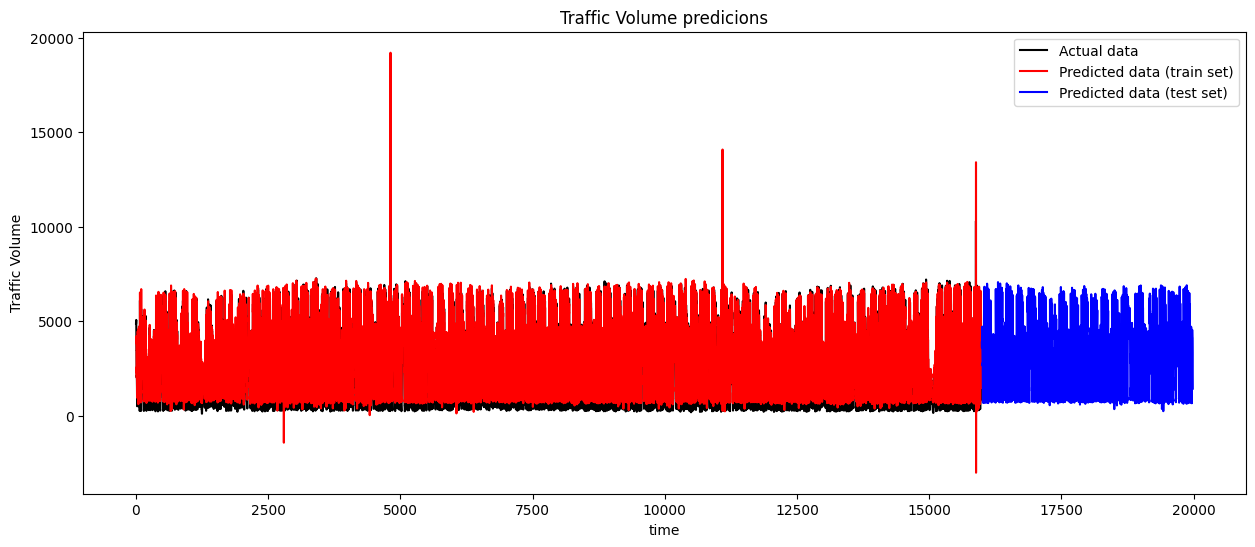

In [60]:
look_back = 7

# Ensure the arrays are of type float
trainPredPlot = np.empty_like(new_df, dtype=float)
trainPredPlot[:] = np.nan

trainPredPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

testPredictPlot = np.empty_like(new_df, dtype=float)
testPredictPlot[:] = np.nan

test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:] = test_predict.flatten()
original_scaled_data = scaler.inverse_transform(train_data)

plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label="Actual data")
plt.plot(trainPredPlot, color='red', label="Predicted data (train set)")
plt.plot(testPredictPlot, color='blue', label="Predicted data (test set)")

plt.title("Traffic Volume predicions")
plt.xlabel("time")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()


### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [61]:
train_size = int(len(new_df) * 0.8)
train_size

15988

In [62]:
train_data, test_data = new_df[:train_size], new_df[train_size:]

In [63]:
scaler = MinMaxScaler()
train_data=scaler.fit_transform(np.array(train_data).reshape(-1,1))
test_data= scaler.transform(np.array(test_data).reshape(-1,1))
train_data, test_data

(array([[0.28551716],
        [0.28551716],
        [0.28551716],
        ...,
        [0.10103192],
        [0.07841373],
        [0.04451644]]),
 array([[0.03155748],
        [0.02285817],
        [0.02183825],
        ...,
        [0.12275018],
        [0.08021358],
        [0.05045596]]))

In [64]:
X_train = []
y_train = []
for i in range(n_past,len(train_data)):
    X_train.append(train_data[i-n_past:i,0])
    y_train.append(train_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [65]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [66]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1],1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1),
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

C:\Users\abo_O\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0085
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0021
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0017
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0017
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0015
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0016
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0014
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0014
Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0015
Epoch 10/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0014
Epoch 11/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0014
Epoch 12/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0013
Epoch 13/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0013
Epoch 14/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0013
Epoch 15/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [68]:
dataset_total = pd.concat((df["traffic_volume"][:train_size], df["traffic_volume"][train_size:]), axis=0)
inputs = dataset_total[len(dataset_total)-len(test_data)-n_past:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [69]:
X_test = []
for i in range(n_past,len(test_data)+n_past):
    X_test.append(inputs[i-n_past:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [70]:
return_rmse(test_data, pred_price)

The root mean squared error is 3847.049076915086.


In [71]:
test_data = scaler.inverse_transform(test_data)

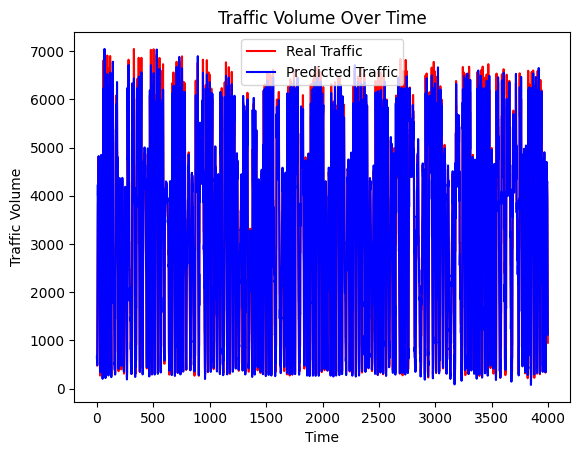

In [72]:
plot_pred(test_data, pred_price)

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

## Project Answers:

1. **Data Preprocessing**:
I checked for missing values in the trrafic volume column becouse it's the target for our timeserios forecasting I also checked for duplcates and handled them I use MinMaxscaler to normlixize the data for easier model training I also removed outliers in the traffic volume column 
2. **Feature Engineering**:
I got the Moving Average of three number of days to see if there is any patrens that might help in training the model I also got the month from date_time to see the monthly seasonalty of the data and got the isWeekend column to check for Weekend traffic
3. **Model Architecture**: 
in the RNN model I used two layers of 50 units to see if that was enough and the model got a very good result according to the graph above for the LSTM model I used the same layers as RNN to see if it would work as well but unfortunately it not work and it seemd to be overfitting 
4. **Training Process**:
I choose the batch size and epochs randomly I did change the batch and epochs in the LSTM model 
5. **Loss Function and Metrics**: 
I choose RMSE becouse it shows the root mean squared error which shows the differnce between predicted and actual data
6. **Model Tuning (If Done)**:
I chnaged the layers on the LSTM model becouse it was overfitting and I changed the batch and epochs size just to expermint and see if the overfitting is solved 
7. **Overfitting and Underfitting**:
OK soooo I thought the LSTM model was overfitting but I relized that I forgot to inverse transform the test data and that's why the graph looked like it was overfitting lol :)
8. **Future Improvements**: 
maybe I could experemint with different layer and number of epochs and batchs to see if i could imporve the models more and maybe try GRU, SARIMA and ARIMA